# Cell Type Analysis for K Means Clustering

In [1]:
library(Seurat)
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
k_means_seurat <- readRDS("k_means_seurat.rds")
#head(k_means_seurat)
#str(k_means_seurat)

# Calculate the percentage of mitochondrial genes
 k_means_seurat[["percent.mt"]] <- PercentageFeatureSet(k_means_seurat, pattern = "^mt-")

# Filter out cells with > 5% mitochondrial gene expression (adjust threshold as necessary)
 k_means_seurat <- subset(k_means_seurat, subset = percent.mt < 5)



In [3]:
# Load marker gene list from Excel
marker_genes <- read_excel("cell_types.xlsx", skip = 1)

# Ensure marker_genes has columns: "CellType" and "Gene"
# head(marker_genes)

#re-format dataframe to be ideal for identifying cell types

# Assuming your data is stored in a variable called marker_genes
cell_type_df <- marker_genes %>%
  pivot_longer(cols = everything(), names_to = "Cell_Type", values_to = "Gene") %>%
  drop_na()  # Remove any NA values if present

# View the reformatted table
head(cell_type_df)

Cell_Type,Gene
<chr>,<chr>
Astrocyte,1110054M08Rik
Oligodendrocyte,0610007P14Rik
OPC,Pdgfra
Microglia,0610031J06Rik
VLMC,Slc6a13
Ependymal,0610009L18Rik


In [4]:
# Create a vector to store the cell types
cell_type_assignments <- rep(NA, nrow(k_means_seurat[["RNA"]]))  # Placeholder for cell type assignments

# Loop through each cell type and assign it to genes in the Seurat object
for (i in 1:nrow(cell_type_df)) {
  # Extract gene and corresponding cell type
  gene_name <- cell_type_df$Gene[i]
  cell_type <- cell_type_df$Cell_Type[i]
  
  # Check if the gene is present in the row names of the Seurat RNA assay
  if (gene_name %in% rownames(k_means_seurat[["RNA"]])) {
    # Find the indices of rows (genes) that match the gene in the Seurat object
    matching_indices <- which(rownames(k_means_seurat[["RNA"]]) == gene_name)
    
    # Assign the cell type to the corresponding indices
    cell_type_assignments[matching_indices] <- cell_type
  }
}

# Add cell type assignments to metadata
k_means_seurat$cell_type <- cell_type_assignments
sum(is.na(cell_type_assignments))
# Now you can visualize or analyze the cell types in the Seurat object
# For example, using UMAP colored by cell type
#DimPlot(k_means_seurat, group.by = "cell_type")

# Label known cell types, leave unknowns as "Unknown"
# k_means_seurat$cell_type <- ifelse(is.na(k_means_seurat$cell_type), "Unknown", k_means_seurat$cell_type)

[1] 21003

In [5]:
# Step 2: Assign missing values based on most common cell type per cluster  
cluster_ids <- Idents(k_means_seurat)  
cluster_modes <- tapply(k_means_seurat$cell_type, cluster_ids, function(x) {  
  x <- x[!is.na(x)]  # Remove NAs  
  if (length(x) == 0) return(NA)  # Keep NA for now if no known types  
  names(which.max(table(x)))  # Most frequent cell type  
})  

# Replace NAs with the most common cell type in the cluster  
k_means_seurat$cell_type <- ifelse(  
  is.na(k_means_seurat$cell_type),  
  cluster_modes[as.character(cluster_ids)],  
  k_means_seurat$cell_type  
)  

# Step 3: Assign remaining "Unknown" cells based on the most common cell type overall  
most_common_type <- names(which.max(table(k_means_seurat$cell_type[!is.na(k_means_seurat$cell_type)])))  


# Check if any NAs remain  
sum(is.na(k_means_seurat$cell_type))  
sum(k_means_seurat$cell_type == "Unknown")


[1] 0

[1] 0

In [6]:
# Run PCA
k_means_seurat <- RunPCA(k_means_seurat, npcs = 30, verbose = FALSE)

# Run UMAP
k_means_seurat <- RunUMAP(k_means_seurat, dims = 1:30)

unique_cells <- !duplicated(k_means_seurat@reductions$pca@cell.embeddings)
k_means_seurat <- subset(k_means_seurat, cells = colnames(k_means_seurat)[unique_cells])

# Run t-SNE
k_means_seurat <- RunTSNE(k_means_seurat, dims = 1:30)


# Define colors for experiments (WT1, WT2, Mutant1, Mutant2)
experiment_colors <- c("WT1" = "#1b9e77", "WT2" = "#d95f02", 
                       "Mutant1" = "#7570b3", "Mutant2" = "#e7298a")

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:45:10 UMAP embedding parameters a = 0.9922 b = 1.112

14:45:10 Read 3172 rows and found 30 numeric columns

14:45:10 Using Annoy for neighbor search, n_neighbors = 30

14:45:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:45:11 Writing NN index file to temp file /tmp/RtmpcGgVG2/file24079884f50

14:45:11 Searching Annoy index using 1 thread, search_k = 3000

14:45:12 Annoy recall = 100%

14:45:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

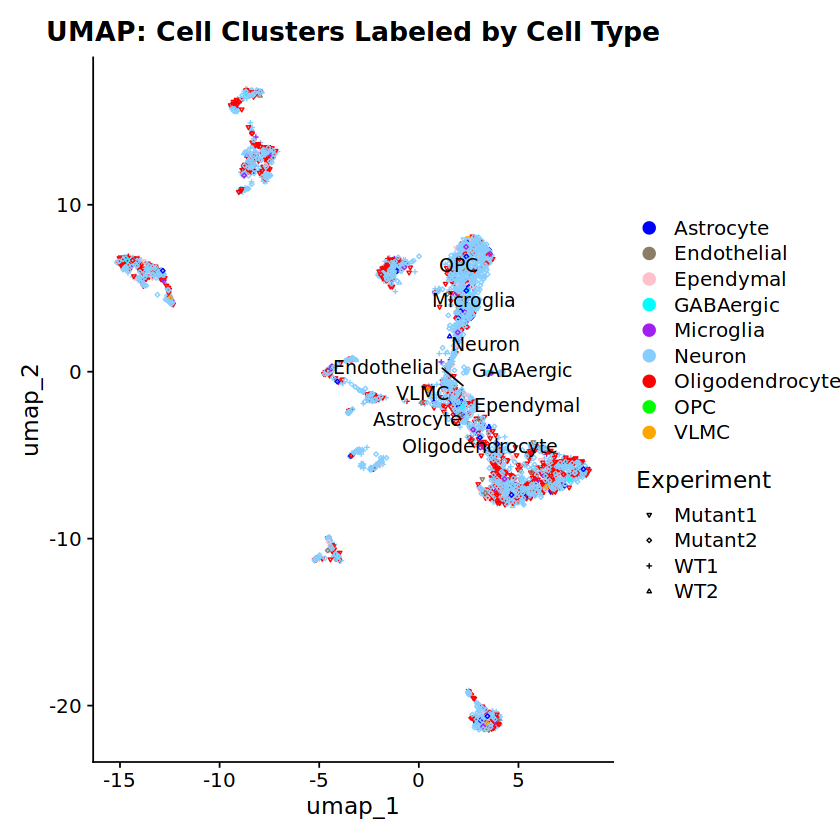

In [8]:
k_means_seurat$cell_type <- factor(k_means_seurat$cell_type) 

DimPlot(k_means_seurat, reduction = "umap", 
        group.by = "cell_type",   # Colors by cell type
        shape.by = "Experiment",  # Different dot shapes for experiments
        label = TRUE,             # Labels clusters by predicted cell type
        repel = TRUE) + 
  ggtitle("UMAP: Cell Clusters Labeled by Cell Type") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink", 
                                "Neuron" = "skyblue1", "GABAergic" = "cyan", "Endothelial" = "wheat4")) +  # Adjust colors for cell types
  scale_shape_manual(values = c("WT1" = 3, "WT2" = 24, "Mutant1" = 6, "Mutant2" = 5))  # More distinct shapes for experiments

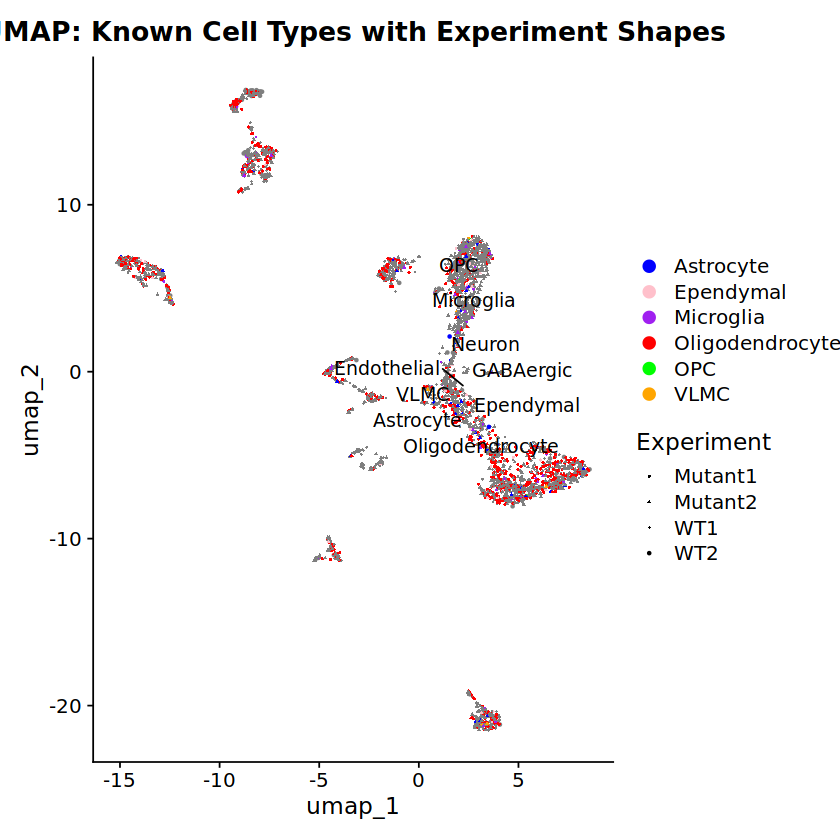

In [29]:
# Filter Seurat object to include only known cell types
known_cell_types_seurat <- subset(k_means_seurat, subset = !is.na(cell_type) & cell_type != "Unknown")

# Create UMAP plot for only known cell types with different shapes for experiments
DimPlot(known_cell_types_seurat, reduction = "umap", 
        group.by = "cell_type",   # Color by known cell type
        shape.by = "Experiment",  # Different shapes for each experiment
        label = TRUE,              # Add labels to clusters
        repel = TRUE) + 
  ggtitle("UMAP: Known Cell Types with Experiment Shapes") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink")) +
  scale_shape_manual(values = c(16, 17, 18, 19))  # Use different shapes for each experiment

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


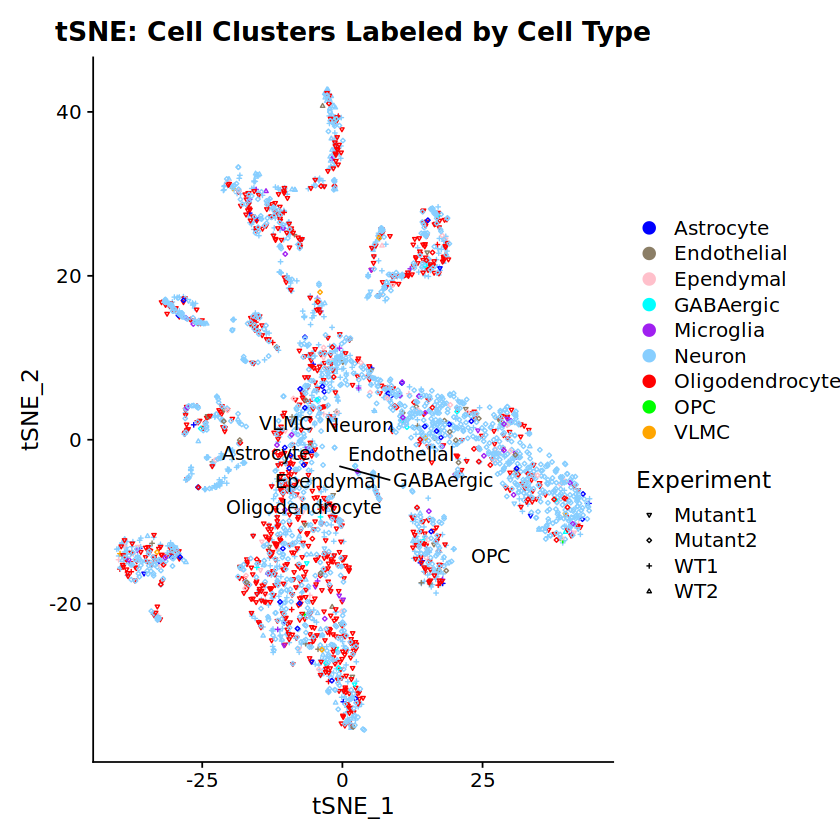

In [36]:
DimPlot(k_means_seurat, reduction = "tsne", 
        group.by = "cell_type",   # Colors by cell type
        shape.by = "Experiment",  # Different dot shapes for experiments
        label = TRUE,             # Labels clusters by predicted cell type
        repel = TRUE) + 
  ggtitle("tSNE: Cell Clusters Labeled by Cell Type") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink", 
                                "Neuron" = "skyblue1", "GABAergic" = "cyan", "Endothelial" = "wheat4")) +  # Adjust colors for cell types
  scale_shape_manual(values = c("WT1" = 3, "WT2" = 24, "Mutant1" = 6, "Mutant2" = 5))  # More distinct shapes for experiments

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


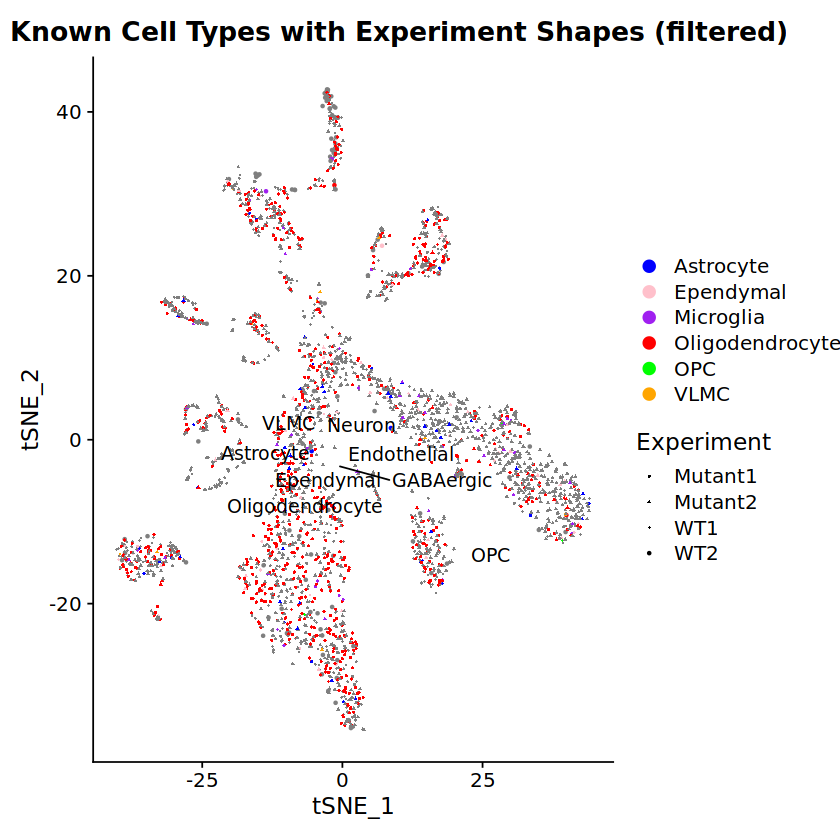

In [33]:
# Filter Seurat object to include only known cell types
known_cell_types_seurat <- subset(k_means_seurat, subset = !is.na(cell_type) & cell_type != "Unknown")

# Create UMAP plot for only known cell types with different shapes for experiments
DimPlot(known_cell_types_seurat, reduction = "tsne", 
        group.by = "cell_type",   # Color by known cell type
        shape.by = "Experiment",  # Different shapes for each experiment
        label = TRUE,              # Add labels to clusters
        repel = TRUE) + 
  ggtitle("tSNE: Known Cell Types with Experiment Shapes (filtered)") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink")) +
  scale_shape_manual(values = c(16, 17, 18, 19))  # Use different shapes for each experiment

# Cell Type Analysis for Louvain Clustering


In [46]:
louvain_seurat <- readRDS("seurat_louvain_clusters.rds")
#head(k_means_seurat)
#str(k_means_seurat)

# Calculate the percentage of mitochondrial genes
louvain_seurat[["percent.mt"]] <- PercentageFeatureSet(louvain_seurat, pattern = "^mt-")

# Filter out cells with > 5% mitochondrial gene expression (adjust threshold as necessary)
louvain_seurat <- subset(louvain_seurat, subset = percent.mt < 5)

str(louvain_seurat)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 9
  .. .. .. .. ..$ counts.WT1    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:755286] 0 1 2 3 4 5 6 7 8 9 ...
  .. .. .. .. .. .. ..@ p       : int [1:799] 0 12784 25091 36388 47679 57878 67666 76060 84359 89726 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 21863 798
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:755286] 1 4 26 174 2 14 1 2 1 6 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts.WT2    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:94219] 1 2 3 10 11 14 15 17 20 21 ...
  .. .. .. .. .. .. ..@ p       : int [1:121] 0 5869 9611 13383 16425 19557 2267

In [47]:
# Load marker gene list from Excel
marker_genes <- read_excel("cell_types.xlsx", skip = 1)

# Ensure marker_genes has columns: "CellType" and "Gene"
# head(marker_genes)

#re-format dataframe to be ideal for identifying cell types

# Assuming your data is stored in a variable called marker_genes
cell_type_df <- marker_genes %>%
  pivot_longer(cols = everything(), names_to = "Cell_Type", values_to = "Gene") %>%
  drop_na()  # Remove any NA values if present

# View the reformatted table
head(cell_type_df)

Cell_Type,Gene
<chr>,<chr>
Astrocyte,1110054M08Rik
Oligodendrocyte,0610007P14Rik
OPC,Pdgfra
Microglia,0610031J06Rik
VLMC,Slc6a13
Ependymal,0610009L18Rik


In [48]:
# Create a vector to store the cell types
cell_type_assignments <- rep(NA, nrow(louvain_seurat[["RNA"]]))  # Placeholder for cell type assignments

# Loop through each cell type and assign it to genes in the Seurat object
for (i in 1:nrow(cell_type_df)) {
  # Extract gene and corresponding cell type
  gene_name <- cell_type_df$Gene[i]
  cell_type <- cell_type_df$Cell_Type[i]
  
  # Check if the gene is present in the row names of the Seurat RNA assay
  if (gene_name %in% rownames(louvain_seurat[["RNA"]])) {
    # Find the indices of rows (genes) that match the gene in the Seurat object
    matching_indices <- which(rownames(louvain_seurat[["RNA"]]) == gene_name)
    
    # Assign the cell type to the corresponding indices
    cell_type_assignments[matching_indices] <- cell_type
  }
}

# Add cell type assignments to metadata
louvain_seurat$cell_type <- cell_type_assignments
sum(is.na(cell_type_assignments))


[1] 21003

In [49]:
# Step 2: Assign missing values based on most common cell type per cluster  
cluster_ids <- Idents(louvain_seurat)  
cluster_modes <- tapply(louvain_seurat$cell_type, cluster_ids, function(x) {  
  x <- x[!is.na(x)]  # Remove NAs  
  if (length(x) == 0) return(NA)  # Keep NA for now if no known types  
  names(which.max(table(x)))  # Most frequent cell type  
})  

# Replace NAs with the most common cell type in the cluster  
louvain_seurat$cell_type <- ifelse(  
  is.na(louvain_seurat$cell_type),  
  cluster_modes[as.character(cluster_ids)],  
  louvain_seurat$cell_type  
)  

# Step 3: Assign remaining "Unknown" cells based on the most common cell type overall  
most_common_type <- names(which.max(table(louvain_seurat$cell_type[!is.na(louvain_seurat$cell_type)])))  

louvain_seurat$cell_type <- ifelse(  
  is.na(louvain_seurat$cell_type) | louvain_seurat$cell_type == "Unknown",  
  most_common_type,  
  louvain_seurat$cell_type  
)  

# Check if any NAs remain  
sum(is.na(louvain_seurat$cell_type))  
sum(louvain_seurat$cell_type == "Unknown")


[1] 0

[1] 0

In [50]:
# Run PCA
louvain_seurat <- RunPCA(louvain_seurat, npcs = 30, verbose = FALSE)

# Run UMAP
louvain_seurat <- RunUMAP(louvain_seurat, dims = 1:30)

unique_cells <- !duplicated(louvain_seurat@reductions$pca@cell.embeddings)
louvain_seurat <- subset(louvain_seurat, cells = colnames(louvain_seurat)[unique_cells])

# Run t-SNE
louvain_seurat <- RunTSNE(louvain_seurat, dims = 1:30)


# Define colors for experiments (WT1, WT2, Mutant1, Mutant2)
#experiment_colors <- c("WT1" = "#1b9e77", "WT2" = "#d95f02", 
                      # "Mutant1" = "#7570b3", "Mutant2" = "#e7298a")

22:39:25 UMAP embedding parameters a = 0.9922 b = 1.112

22:39:25 Read 3172 rows and found 30 numeric columns

22:39:25 Using Annoy for neighbor search, n_neighbors = 30

22:39:25 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:39:25 Writing NN index file to temp file /tmp/RtmprHG9l6/file3b97316f6764d

22:39:25 Searching Annoy index using 1 thread, search_k = 3000

22:39:26 Annoy recall = 100%

22:39:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:39:27 12 smooth knn distance failures

22:39:27 Initializing from normalized Laplacian + noise (using RSpectra)

22:39:27 Commencing optimization for 500 epochs, with 137554 positive edges

22:39:37 Optimization finished



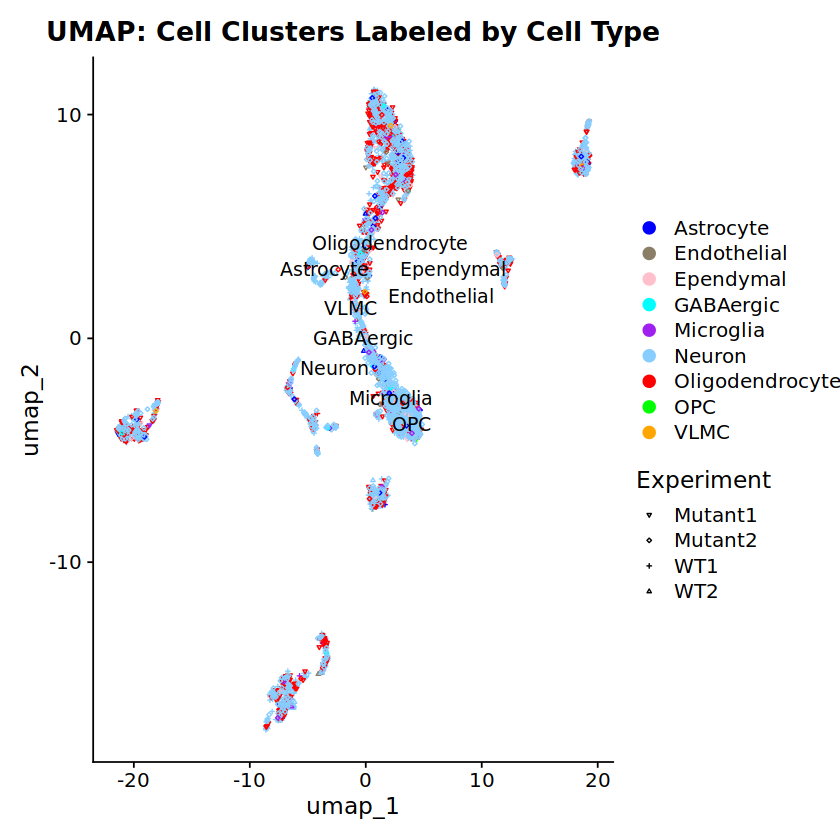

In [52]:
DimPlot(louvain_seurat, reduction = "umap", 
        group.by = "cell_type",   # Colors by cell type
        shape.by = "Experiment",  # Different dot shapes for experiments
        label = TRUE,             # Labels clusters by predicted cell type
        repel = TRUE) + 
  ggtitle("UMAP: Cell Clusters Labeled by Cell Type") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink", 
                                "Neuron" = "skyblue1", "GABAergic" = "cyan", "Endothelial" = "wheat4")) +  # Adjust colors for cell types
  scale_shape_manual(values = c("WT1" = 3, "WT2" = 24, "Mutant1" = 6, "Mutant2" = 5))  # More distinct shapes for experiments

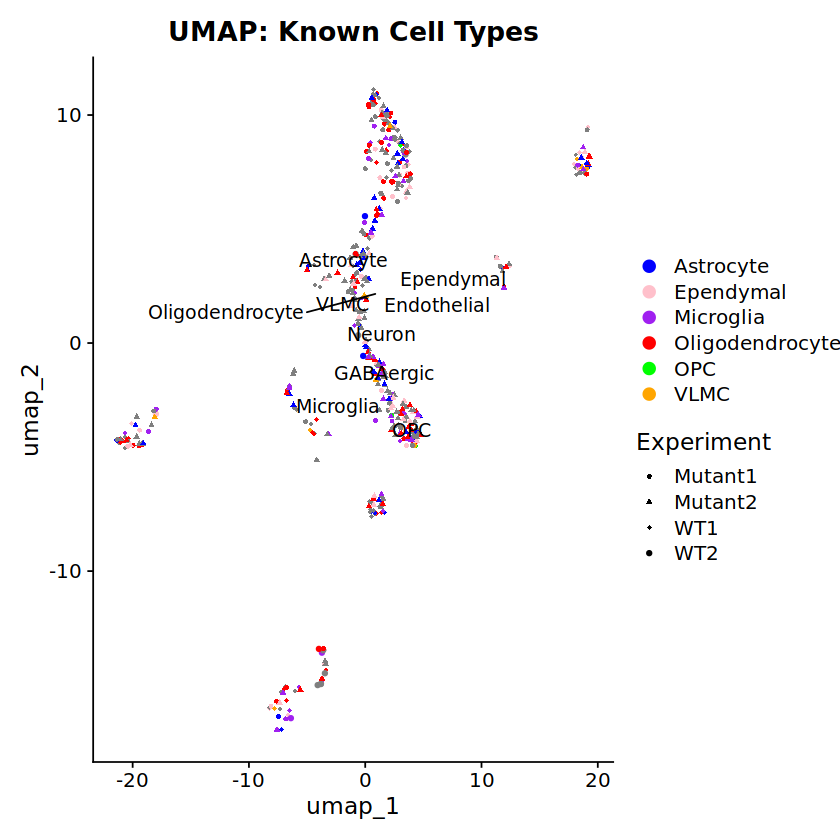

In [15]:
# Filter Seurat object to include only known cell types
known_cell_types_seurat <- subset(louvain_seurat, subset = !is.na(cell_type) & cell_type != "Unknown")

# Create UMAP plot for only known cell types with different shapes for experiments
DimPlot(known_cell_types_seurat, reduction = "umap", 
        group.by = "cell_type",   # Color by known cell type
        shape.by = "Experiment",  # Different shapes for each experiment
        label = TRUE,              # Add labels to clusters
        repel = TRUE) + 
  ggtitle("UMAP: Known Cell Types") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink")) +
  scale_shape_manual(values = c(16, 17, 18, 19))  # Use different shapes for each experiment

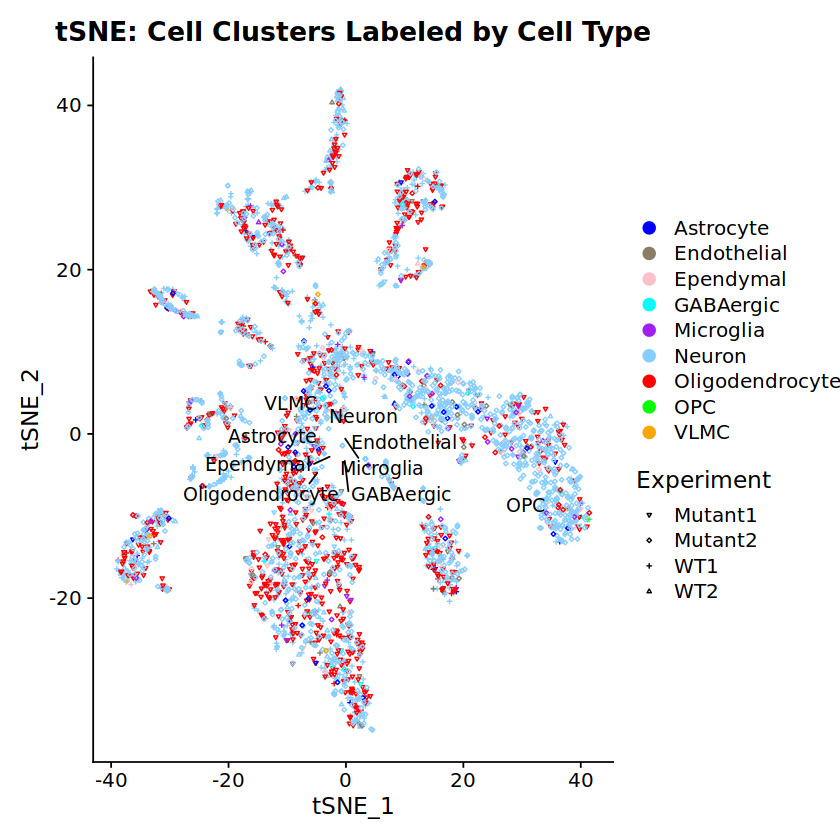

In [53]:
DimPlot(louvain_seurat, reduction = "tsne", 
        group.by = "cell_type",   # Colors by cell type
        shape.by = "Experiment",  # Different dot shapes for experiments
        label = TRUE,             # Labels clusters by predicted cell type
        repel = TRUE) + 
  ggtitle("tSNE: Cell Clusters Labeled by Cell Type") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink", 
                                "Neuron" = "skyblue1", "GABAergic" = "cyan", "Endothelial" = "wheat4")) +  # Adjust colors for cell types
  scale_shape_manual(values = c("WT1" = 3, "WT2" = 24, "Mutant1" = 6, "Mutant2" = 5))  # More distinct shapes for experiments

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


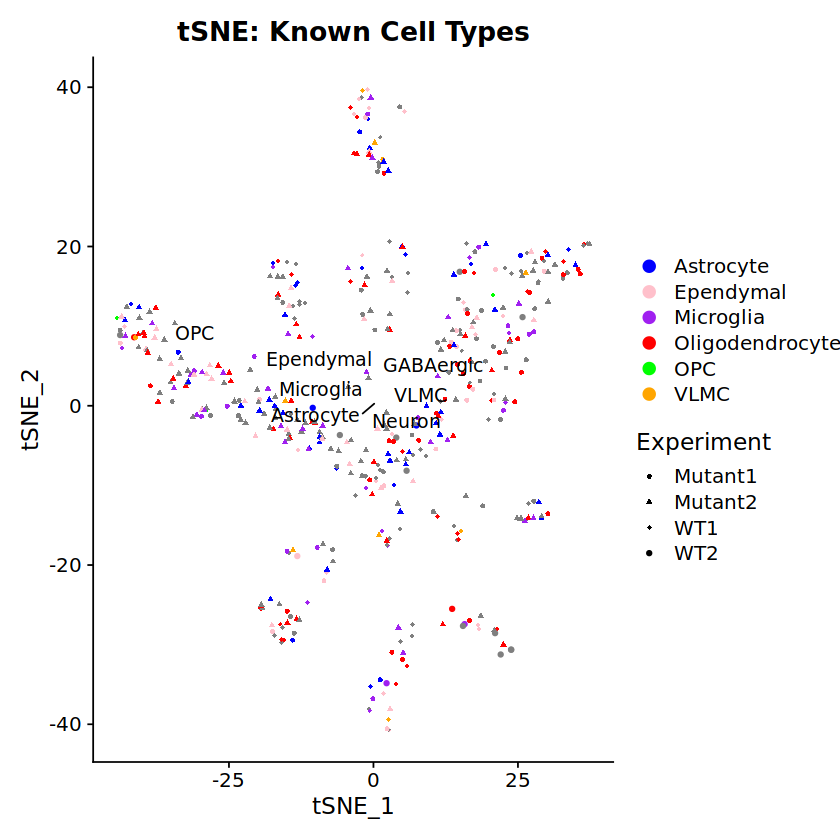

In [17]:
# Filter Seurat object to include only known cell types
known_cell_types_seurat <- subset(louvain_seurat, subset = !is.na(cell_type) & cell_type != "Unknown")

# Create UMAP plot for only known cell types with different shapes for experiments
DimPlot(known_cell_types_seurat, reduction = "tsne", 
        group.by = "cell_type",   # Color by known cell type
        shape.by = "Experiment",  # Different shapes for each experiment
        label = TRUE,              # Add labels to clusters
        repel = TRUE) + 
  ggtitle("tSNE: Known Cell Types") +
  scale_color_manual(values = c("Astrocyte" = "blue", "Oligodendrocyte" = "red", 
                                "OPC" = "green", "Microglia" = "purple", 
                                "VLMC" = "orange", "Ependymal" = "pink")) +
  scale_shape_manual(values = c(16, 17, 18, 19))  # Use different shapes for each experiment

# Generate DEG across cell types lists

K means

In [58]:
# Add merged counts to Seurat object

combined_counts_matrix <- readRDS("combined_counts_matrix2.rds")

#k_means_seurat[["combined"]] <- CreateAssayObject(counts = combined_counts_matrix)


# sum(colnames(k_means_seurat) %in% colnames(combined_counts_matrix))

common_cells <- colnames(k_means_seurat)  # Extract cell names from Seurat object
combined_counts_matrix <- combined_counts_matrix[, common_cells, drop = FALSE]

print(dim(combined_counts_matrix))  # Should now be 23903 genes × 3167 cells
print(length(colnames(k_means_seurat)))  # Should be 3167

# Set the active assay to the newly created combined assay
DefaultAssay(k_means_seurat) <- "combined"

deg_results <- FindAllMarkers(k_means_seurat, 
                    #          group.by = "cell_type",  # Compare across cell types
                    #          only.pos = FALSE,        # Get both up- and downregulated genes
                    #          min.pct = 0.25,          # Filter genes expressed in <25% of cells
                    #          logfc.threshold = 0.25)  # Require log fold change > 0.25


[1] 23903 15472
[1] 3167
[1] 3167


[1] 3167

[1] 23903  3167
[1] 3167


ERROR: Error in match.arg(arg = value, choices = Assays(object = object)): 'arg' should be “RNA”


In [13]:
# save seurat object with cell types
saveRDS(k_means_seurat, file = "k_seurat_CT")

In [ ]:
write.csv(deg_results, "Kmeans_DEGs.csv", row.names = FALSE)

Louvain

In [ ]:
# Add merged counts to Seurat object

combined_counts_matrix <- readRDS("combined_counts_matrix2.rds")

louvain_seurat[["combined"]] <- CreateAssayObject(counts = combined_counts_matrix)

# Set the active assay to the newly created combined assay
DefaultAssay(louvain_seurat) <- "combined"

deg_results <- FindAllMarkers(louvain_seurat, 
                              group.by = "cell_type",  # Compare across cell types
                              only.pos = FALSE,        # Get both up- and downregulated genes
                              min.pct = 0.25,          # Filter genes expressed in <25% of cells
                              logfc.threshold = 0.25)  # Require log fold change > 0.25

head(deg_results)

In [14]:
# save seurat object with cell types
saveRDS(louvain_seurat, file = "L_seurat_CT")

In [ ]:
write.csv(deg_results, "Louvain_DEGs.csv", row.names = FALSE)